In [1]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
pf.housestyle_rcparams()

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

from scipy.stats import gaussian_kde

import logging

mycolors = ['#570f6d', "#9e8f92", '#f98e08']
folly = '#ff004f'

In [ ]:
glob_sigma = 1
glob_bkg = True
glob_pve_bounds = False
glob_det = 'det'
glob_locks = [True, True, True] # mu amp sigma

# Nsims = 100_000
Nbins = 1024
train_bounds = 5

# simulator = Simulator_Additive(100,1,5,0.02,mode='gw', bkg=False)
# simulator = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=train_bounds, 
#                                fraction=0.2, bkg=glob_bkg, dtype=torch.float64, 
#                                mode='gw', bump=glob_det, frange=[20,240],
#                                lock_mu=glob_locks[0],lock_amp=glob_locks[1], lock_sigma=glob_locks[2])

simulator = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=train_bounds, 
                               fraction=0.2, bkg=glob_bkg, dtype=torch.float64, 
                               mode='gw', bump=glob_det, frange=[10,500])

simulator._init_gw()
Nbins = len(simulator.grid_chopped)

quantiles = np.array([0.05199686, 0.2145543,  0.58780088, 1.17737921, 1.91882754,
 2.75067576, 3.63463655])

quantiles_long = np.array([7.11978022e-04, 7.96148769e-03, 5.19968566e-02, 2.14554300e-01,
 5.87800876e-01, 1.17737921e+00, 1.91882754e+00, 2.75067576e+00,
 3.63463655e+00, 4.55164698e+00, 5.49045819e+00])

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from ../../mist-base/GW/GW150814_posterior_samples.npz


In [3]:
netid = 'GW_b_240'

/tmp/ipykernel_886020/1285749911.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_886020/1285749911.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


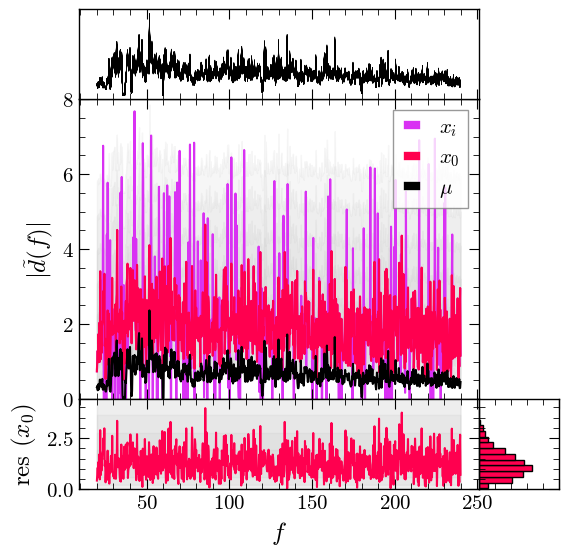

In [8]:
test=simulator.sample(1)
grid = simulator.grid_chopped
pf.housestyle_rcparams()
fig, ax1 = pf.create_plot()

plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = fig.add_axes((0,-.3,1,0.3), sharex=ax1)
ax3 = fig.add_axes((1,-.3,0.2,0.3), sharey=ax2)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
ax4 = fig.add_axes((0,1,1,0.3), sharex=ax1)
plt.setp(ax4.get_xticklabels(), visible=False)

ax1.plot(grid,test['xi'][0], label=r'$x_i$', color="#d931f3")
ax1.plot(grid,test['x0'][0], label=r'$x_0$', color='#ff004f')
ax1.plot(grid,test['mu'][0], label=r'$\mu$', color='black')
ax1.set_ylabel(r'$|\tilde{d}(f)|$')
ax1.set_ylim([0,8])
ax1.legend(loc='upper right')


resd = test['x0'][0]-test['mu'][0]
ax2.plot(grid, resd, color='#ff004f')
ax2.set_xlabel(r'$f$')
ax2.set_ylabel(r'res ($x_0$)')
ax2.set_ylim([0,4.4])

for i in range(1,6):
    ax1.fill_between(grid, quantiles_long[i]+test['mu'][0], quantiles_long[-i]+test['mu'][0],  color='#b0b0b0', alpha=0.1)
    ax2.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)
    ax3.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)

ax3.hist(resd, orientation='horizontal', bins=14, edgecolor='black', color='#ff004f', density=True)
ax3.set_xlim([0,1])

for i in range(100):
    ax4.plot(grid, simulator.sample(1)['mu'][0], lw=0.5, color='black', alpha=0.5)

ax4.set_yticks([])

pf.fix_plot([ax1,ax2, ax3,ax4])
plt.tight_layout()

plt.tight_layout()
plt.savefig(f'figs/{netid}/distribution.png', bbox_inches='tight', dpi=400)


In [11]:
from models.online_norm import OnlineStandardizingLayer
from models.unet_1d import UNet1d 
from models.resnet_1d import ResidualNet


class Network_BCE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = UNet1d(1, 1, sizes=(8, 16, 32, 64, 128))
        # self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 
        self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=False) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x

In [17]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']    
    for k, v in sample.items():
        if v.ndim > 1:
            sample[k] = v.squeeze(0)
    return sample

batch_size = 128
samples = simulator.sample(Nsims=1000)  
dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
# dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size)
network_epsilon = Network_BCE()
model = BCELossModule(network_epsilon, learning_rate=8e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=100, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_epsilon.cuda().eval();

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | Network_BCE | 181 K  | train
----------------------------------------------
181 K     Trainable params
0         Non-trainable params
181 K     Total params
0.725     Total estimated model params size (MB)
99        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Reloading best model: /data/tgh35/summer25/gw-mist/notebooks/week8/lightning_logs/version_3/checkpoints/epoch=28-val_loss=0.57.ckpt


In [18]:
torch.save(network_epsilon, f'networks/network_BCE_{netid}_complex')
torch.save(model, f'networks/model_BCE_{netid}_complex')

In [19]:
network_BCE = network_epsilon

In [22]:
def dict_to_mps(x):
    if isinstance(x, dict):
        return {k: dict_to_mps(v) for k, v in x.items()}
    elif isinstance(x, torch.Tensor):
        return x.to(device='mps')
    elif isinstance(x, list):
        return [dict_to_mps(item) for item in x]
    else:
        return x

def dict_to_cuda(x):
    if isinstance(x, dict):
        return {k: dict_to_cuda(v) for k, v in x.items()}
    elif isinstance(x, torch.Tensor):
        return x.to(device='cuda')
    elif isinstance(x, list):
        return [dict_to_cuda(item) for item in x]
    else:
        return x

def dict_to_cpu(x: dict) -> dict:
    out = {}
    for key, val in x.items():
        if isinstance(val, torch.Tensor):
            out[key] = val.to(device='cpu')
        else:
            out[key] = val
    return out


def pvalue_grid_eps(dat):
    eps_t_mean = np.mean(ts_bin_H0_epsilon, axis=0)
    eps_t_ref = ts_bin_H0_epsilon - eps_t_mean
    counts = np.sum(eps_t_ref >= dat[:, np.newaxis, :], axis=1)
    return (counts + 1) / (len(eps_t_ref) + 1)

def pvalue_grid_BCE(dat):
    BCE_t_mean = np.mean(ts_bin_H0_BCE, axis=0)
    BCE_t_ref = ts_bin_H0_BCE - BCE_t_mean
    counts = np.sum(BCE_t_ref >= dat[:, np.newaxis, :], axis=1)
    return (counts + 1) / (len(BCE_t_ref) + 1)

def chop_middle(array, remove=5, linemode=True):
    if len(array)%2==0:
        mid_u = int(len(array)/4)
        mid_d = mid_u -1
        if not linemode:
            return np.concatenate([array[:mid_d-remove], array[mid_u+remove:]])
        else:
            return array[:mid_d-remove] , array[mid_u+remove:], array[mid_u]
    else:
        mid = len(array)//2
        if not linemode:
            return np.concatenate([array[:mid-remove], array[mid+remove:]])
        else:
            return array[:mid-remove], array[mid+remove:], array[mid]
        
def get_snr2(input:dict):
    target = input['x']
    snr2_nn = network_epsilon.snr(target.cuda()).detach().cpu().numpy()**2 
    return snr2_nn

def local_do_ticks(list_of_axes, dir = 'in'):
    for ax in list_of_axes:
        ax.minorticks_on()
        ax.tick_params(top=True,right=True, direction=dir, length=7, which='major')
        ax.tick_params(top=True,right=True, direction=dir, length=4, which='minor')

def local_fix_frame(ax):
    ax.tick_params(color='black', labelcolor='black')
    ax.spines[:].set_color('black')
    ax.spines[:].set_linewidth(1)
    return True

def local_fix_plot(a, tickdir ='in'):
    for axes in a:
        axes.grid(False)
        local_do_ticks([axes], tickdir)
        local_fix_frame(axes)
    return True

def ts_sbi(x: dict, model: int =0):
    # x = dict_to_double(x)
    x = dict_to_cuda(x)
    
    # Test statistic for sample 0 or 1
    if 'x' not in x.keys():
        if model == 0:
            x['x'] = x['x0']
        elif model == 1:
            x['x'] = x['xi'] 

    # Test statistic
    t = 2 * (network_BCE(x).detach().cpu().squeeze(0).numpy())
    
    # Go back to cpu 
    x = dict_to_cpu(x)
    return t

In [23]:
N_mc = 2e6

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
ts_bin_H0_BCE = []
ts_bin_H1_BCE = []
eps_real_BCE = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_bin_H0_BCE.append(ts_sbi(mc_samples, model=0))
    ts_bin_H1_BCE.append(ts_sbi(mc_samples, model=1))
    eps_real_BCE.append(mc_samples['epsilon'])

ts_bin_H0_BCE = np.concatenate(ts_bin_H0_BCE)
ts_bin_H1_BCE = np.concatenate(ts_bin_H1_BCE)
eps_real_BCE = np.concatenate(eps_real_BCE)

ts_bin_H0_BCE.shape

###### SET UP GRID ######
positions = torch.arange(0, Nbins, 1).to(dtype=simulator.dtype)
amplitudes = torch.linspace(-10, 15, 80).to(dtype=simulator.dtype)

position_grid, amplitude_grid = torch.meshgrid(positions,amplitudes)
b = {'x':amplitude_grid.T}

###### DO BCE STATS ######
a = b['x']
s = ts_sbi(b)
dat = [a,s]


fig, ax1 = pf.create_plot()
ax1.set_xlabel(r'$f$')
ax2 = fig.add_axes((1.05, 0,0.1,1))

# ax3 = fig.add_axes((0, 1.1,1,1))
# plt.setp(ax3.get_xticklabels(), visible=False)
# ax4 = fig.add_axes((1.05, 1.1,0.1,1))

axs = [ax1,ax2]


dat = [pvalue_grid_BCE(s)]
lab =  [r'$\mathrm{log}_{10}($p$_{i, \mathrm{SNR}})$']

labcolour = "#000000"

obs = simulator.sample(100)


for q in range(1):
    mesh = axs[2*q].pcolormesh(position_grid.T, amplitude_grid.T, np.log10(dat[q]), cmap='magma', vmin=-8)
    fig.colorbar(mesh,cax=axs[2*q+1], shrink=0.8, label=lab[q])
    axs[2*q+1].set_ylim([-6.5,0])

    for j in range(2):
        axs[2*q].plot(chop_middle(positions)[j], chop_middle(obs['mu'][0])[j], color=labcolour, linewidth=3)
        for i in range(5):
            alp = .5+(i/8)
            axs[2*q].plot(chop_middle(positions)[j], chop_middle(obs['mu'][0]+quantiles[-i])[j], color=labcolour, alpha=alp)

    x = 25
    axs[2*q].text(x,obs['mu'][0][int(x)], r'$\mu$', color=labcolour, size=20)
    sigs = [r'$+3\sigma$',r'$+2\sigma$',r'$+\sigma$',r'$\bar{x}_0$']
    x2 = 25
    ff = torch.Tensor([0,0,0,-1])
    for i in range(4):
        axs[2*q].text(x2,(obs['mu'][0]+quantiles[-i])[int(x2)], sigs[i-1], color=labcolour, size=12, ha='center')  

    axs[2*q].set_ylabel(r'$\tilde{d}(f)$')

local_fix_plot(axs, tickdir='out')

plt.tight_layout()
plt.savefig(f'figs/{netid}/pmaps_test.png', dpi=700, bbox_inches = 'tight')


  0%|          | 0/488 [00:00<?, ?it/s]2025-08-18 20:36:04.918164: W external/xla/xla/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 512.06MiB (rounded to 536936448)requested by op 
2025-08-18 20:36:04.918425: W external/xla/xla/tsl/framework/bfc_allocator.cc:494] ****************************************************************************************************
E0818 20:36:04.918465  886020 pjrt_stream_executor_client.cc:3067] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 536936448 bytes.
  0%|          | 0/488 [00:10<?, ?it/s]


ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 536936448 bytes.